In [ ]:
# Comment the following lines if you're not in colab:
from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-7

In [ ]:
import numpy as np
import torch as tc
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.distributions import Uniform
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

seed = 42
tc.manual_seed(42)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


Same as in the previous notebooks:

In [ ]:
def get_mask(dim, orientation=True):
    return ((1 - tc.arange(dim) % 2) ^ orientation).float()

In [ ]:
class CouplingLayer(nn.Module):

  def __init__(self, inpt_dim, hid_dim, mask, n_layers=4):
    super().__init__()

    self.odd_mask = mask
    self.even_mask = 1 - self.odd_mask

    modules = [
        nn.Linear(inpt_dim, hid_dim),
        nn.ReLU()
    ]

    for _ in range(n_layers - 2):
        modules.append(nn.Linear(hid_dim, hid_dim))
        modules.append(nn.ReLU())
    modules.append(nn.Linear(hid_dim, inpt_dim))

    self.m = nn.Sequential(*modules)

  def forward(self, x):
      x1 = self.odd_mask * x
      x2 = self.even_mask * x
      y1 = x1
      y2 = x2 + (self.m(x1) * self.even_mask)
      return y1 + y2

  # Inverse mapping:
  def inverse(self, x):
    y1 = self.odd_mask * x
    y2 = self.even_mask * x
    x1 = y1
    x2 = y2 - (self.m(y1) * self.even_mask)
    return x1 + x2

In [ ]:
class ScalingLayer(nn.Module):
  def __init__(self, inpt_dim):
    super().__init__()
    self.log_scale_vector = nn.Parameter(tc.zeros(1, inpt_dim, requires_grad=True))

  def forward(self, x):
    log_det_jacobian = tc.sum(self.log_scale_vector)
    scaled_x = tc.exp(self.log_scale_vector) * x
    return scaled_x, log_det_jacobian

  def inverse(self, x):
    return tc.exp(-self.log_scale_vector) * x

## <u>Logistic Prior</u>
Our final improvement for this generative model in this tutorial will be to change the prior distribution. In the original NICE model, a logistic distribution was used for MNIST instead of a Gaussian. Its PDF is given by:
\begin{equation}
f(x) = \frac{e^{-x}}{\left( 1 + e^{-x} \right)^2}.
\end{equation}
### <u>Log PDF</u>
So, taking the log of this expression:
\begin{equation}
\ln\left(f(x)\right) = -x -2\ln(1+e^{-x}) = -\left(x + 2\text{softplus}(-x)\right).
\end{equation}
We can use this expression outright, but there is an alternative which is more numerically stable.
\begin{equation}
\ln\left(f(x)\right) = -\left(\text{softplus}(x) + \text{softplus}(-x)\right).
\end{equation}
You can show that the above expressions are equal; take it as optional homework if you wish.
### <u>Sampling</u>
We can use the *inverse transform sampling* to generate samples from a distribution given its Cumulative Distribution Function (CDF). For our logistic, its CDF is:
\begin{equation}
F(x) = \int_{-\infty}^{x} f(t) dt = \cdots = \frac{1}{1+e^{-x}}.
\end{equation}
To generate a sample from the logistic, we can start with a sample $u$ from a uniform distribution $\mathcal{U}(0,1)$, and then invert the CDF of the logistic to find the $x$ that gives $u$, i.e., we solve $F(x) = u$ for x:
\begin{equation}
x = \ln\left(\frac{u}{1-u}\right) = \ln(u) - \ln(1-u), \ \text{given} \ u = \frac{1}{1+e^{-x}}.
\end{equation}

In [ ]:
class Distribution(ABC):

    @abstractmethod
    def log_prob(self, x):
        pass

    @abstractmethod
    def sample(self, size):
        pass

class LogisticDistribution(Distribution):
  def __init__(self):
    super().__init__()

    self.uniform_dist = Uniform(tc.tensor([0.0]), tc.tensor([1.0]))

  def log_prob(self, x):
    return -(F.softplus(x) + F.softplus(-x))
    # equal to:
    # return -(x + 2*F.softplus(-x))

  def sample(self, size):
    z = self.uniform_dist.sample(size)
    return tc.log(z) - tc.log(1. - z)

## <u>NICE Architecture</u>

Now we are the closest we have been to the original NICE model:

In [ ]:
class NICE(nn.Module):
  def __init__(self, inpt_dim, hid_dim=1000, n_coupling_layers=3, n_layers=6):
    super().__init__()

    self.input_dim = inpt_dim
    self.hidden_dim = hid_dim
    self.num_coupling_layers = n_coupling_layers
    self.num_layers = n_layers
    # This is the only change:
    self.prior = LogisticDistribution()

    # alternating mask orientations for consecutive coupling layers:
    masks = [
        get_mask(inpt_dim, orientation=(i % 2 == 0)).to(device)
        for i in range(n_coupling_layers)
    ]

    self.coupling_layers = nn.ModuleList([
        CouplingLayer(
            inpt_dim=inpt_dim,
            hid_dim=hid_dim,
            mask=masks[i],
            n_layers=n_layers
        )
        for i in range(n_coupling_layers)
    ])
    self.scaling_layer = ScalingLayer(inpt_dim=inpt_dim)


  def forward(self, x):
    z = x
    for i in range(len(self.coupling_layers)):
      z = self.coupling_layers[i](z)
    z, log_det_jacobian = self.scaling_layer(z)
    log_likel = tc.sum(self.prior.log_prob(z), dim=1) + log_det_jacobian
    return z, log_likel

  def inverse(self, z):
    x = z
    x = self.scaling_layer.inverse(x)
    for i in reversed(range(len(self.coupling_layers))):
      x = self.coupling_layers[i].inverse(x)
    return x

  def sample(self, num_samples):
    z = self.prior.sample([num_samples, self.input_dim]).view(num_samples, self.input_dim).to(device)
    return self.inverse(z)

The rest is exactly the same as in the previous notebook:

In [ ]:
length, height = 28, 28   # input size (MNIST)
input_dim = length * height
hidden_dim = 1000         # output size of the hidden layers
num_coupling_layers = 4   # number of coupling layers
num_layers = 5            # number of linear layers for each coupling layer

epochs = 30  # original paper: 1500
batch_size = 128
betas = (0.9, 0.01)
eps = 1e-4
lr = 1e-3

In [ ]:
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.scale_range = scale_range

    def forward(self, img):
        img = img + tc.rand_like(img) / 256.0
        min_val, max_val = self.scale_range
        img = img * (max_val - min_val) + min_val
        return img

# Use the custom transform in a Compose with ToTensor
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    DequantizeAndScale(scale_range=(0, 1))
])

In [ ]:
# Define the dataset and data loader
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define the NICE model
model = NICE(
    inpt_dim=input_dim,
    n_coupling_layers=num_coupling_layers,
    n_layers=num_layers
).to(device)
# may not work in colab:
_ = summary(model=model)

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─CouplingLayer: 2-1                --
|    |    └─Sequential: 3-1              4,572,784
|    └─CouplingLayer: 2-2                --
|    |    └─Sequential: 3-2              4,572,784
|    └─CouplingLayer: 2-3                --
|    |    └─Sequential: 3-3              4,572,784
|    └─CouplingLayer: 2-4                --
|    |    └─Sequential: 3-4              4,572,784
├─ScalingLayer: 1-2                      784
Total params: 18,291,920
Trainable params: 18,291,920
Non-trainable params: 0


## <u>Reconstruction (forward -> inverse) sanity check:</u>

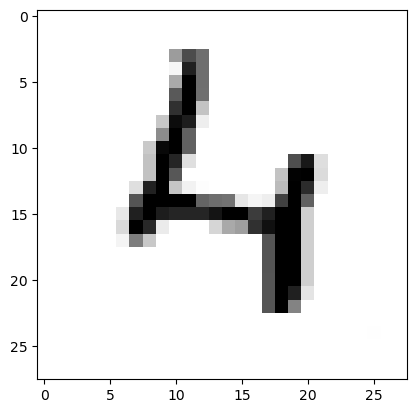

In [ ]:
def reconstruction():
    x_batch, _ = next(iter(train_loader))
    x_batch = x_batch.to(device).view(-1, input_dim)

    out, _ = model(x_batch)
    x_hat = model.inverse(out)

    plt.figure()
    plt.imshow(x_hat[0].detach().cpu().numpy().reshape(height, length), cmap='binary')
    plt.show()

reconstruction()

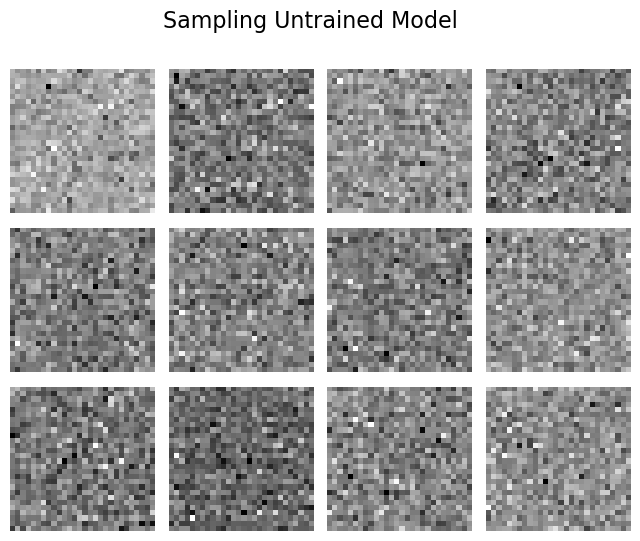

In [ ]:
def sample_model(n_samples=12, title="None"):
    # Model sampling happens here:
    x_hat = model.sample(n_samples)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, 28, 28)
    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, ax in enumerate(axs.flat[:n_samples]):
        ax.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

model.eval()
sample_model(n_samples=12, title="Sampling Untrained Model")

469it [00:14, 33.17it/s]


Epoch 1/30 |  Mean NLL (Loss): 915.4449


469it [00:14, 33.33it/s]


Epoch 2/30 |  Mean NLL (Loss): 553.7271


469it [00:14, 33.02it/s]


Epoch 3/30 |  Mean NLL (Loss): 203.6409


469it [00:14, 32.81it/s]


Epoch 4/30 |  Mean NLL (Loss): -128.9512


469it [00:14, 33.09it/s]


Epoch 5/30 |  Mean NLL (Loss): -429.7091


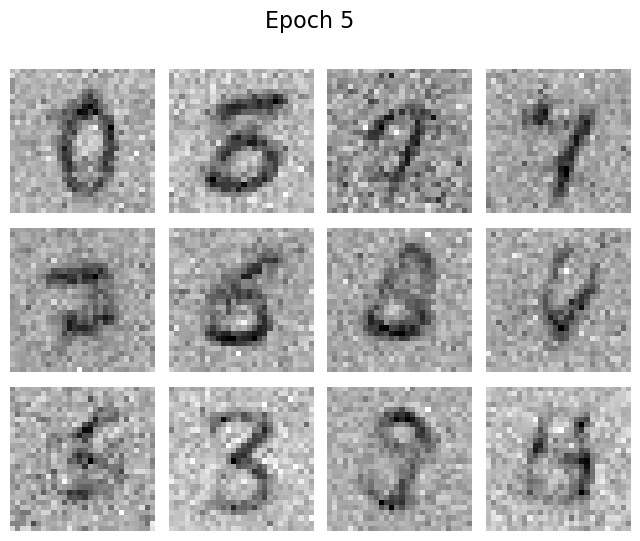

469it [00:14, 33.03it/s]


Epoch 6/30 |  Mean NLL (Loss): -673.4079


469it [00:14, 32.98it/s]


Epoch 7/30 |  Mean NLL (Loss): -878.0449


469it [00:14, 32.97it/s]


Epoch 8/30 |  Mean NLL (Loss): -1056.2180


469it [00:14, 33.38it/s]


Epoch 9/30 |  Mean NLL (Loss): -1207.9422


469it [00:14, 33.11it/s]


Epoch 10/30 |  Mean NLL (Loss): -1330.1957


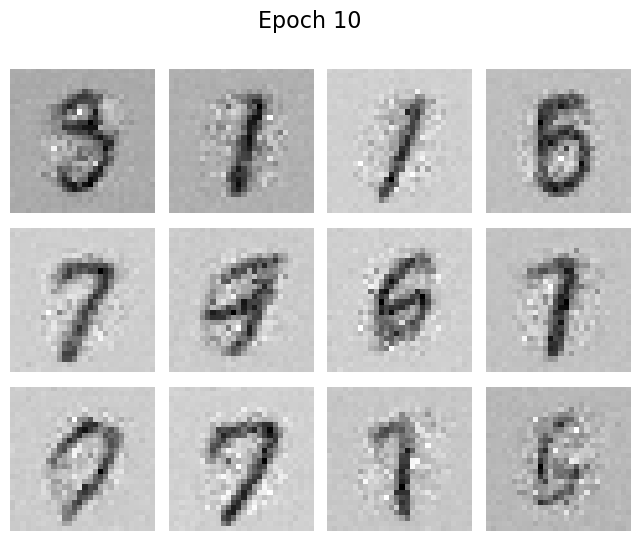

469it [00:14, 32.05it/s]


Epoch 11/30 |  Mean NLL (Loss): -1416.1185


469it [00:14, 32.94it/s]


Epoch 12/30 |  Mean NLL (Loss): -1463.6215


469it [00:13, 33.62it/s]


Epoch 13/30 |  Mean NLL (Loss): -1489.0324


469it [00:13, 33.77it/s]


Epoch 14/30 |  Mean NLL (Loss): -1502.2780


469it [00:13, 34.01it/s]


Epoch 15/30 |  Mean NLL (Loss): -1512.5404


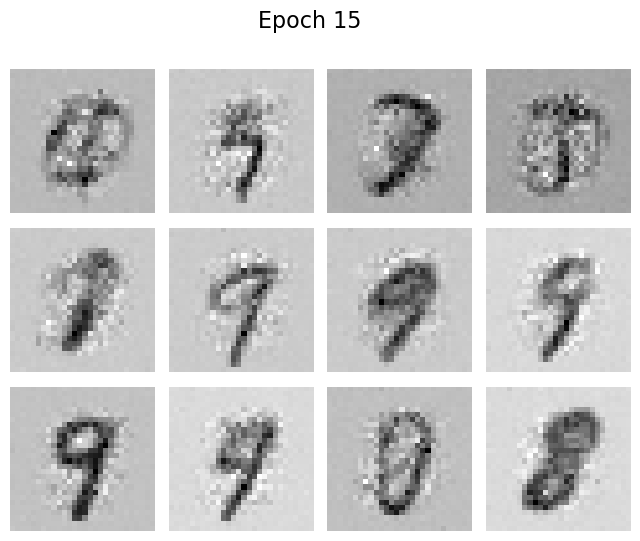

469it [00:13, 33.73it/s]


Epoch 16/30 |  Mean NLL (Loss): -1522.6381


469it [00:13, 33.55it/s]


Epoch 17/30 |  Mean NLL (Loss): -1535.9419


469it [00:14, 33.45it/s]


Epoch 18/30 |  Mean NLL (Loss): -1546.8681


469it [00:13, 33.67it/s]


Epoch 19/30 |  Mean NLL (Loss): -1552.3728


469it [00:14, 33.31it/s]


Epoch 20/30 |  Mean NLL (Loss): -1560.3787


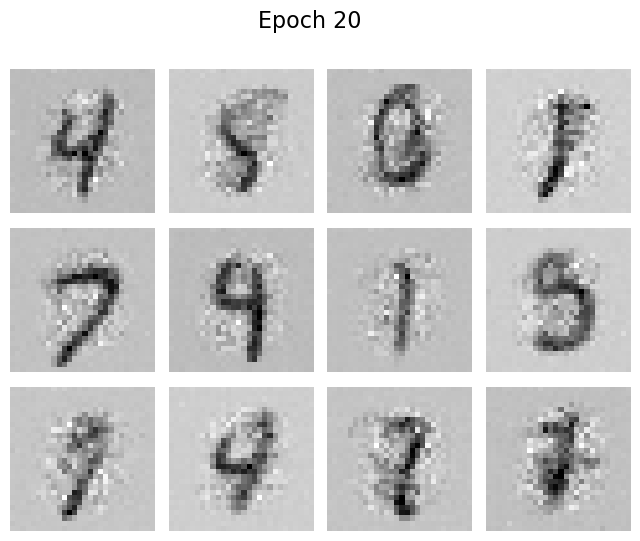

469it [00:14, 32.92it/s]


Epoch 21/30 |  Mean NLL (Loss): -1566.6693


469it [00:14, 32.83it/s]


Epoch 22/30 |  Mean NLL (Loss): -1573.6567


469it [00:14, 32.95it/s]


Epoch 23/30 |  Mean NLL (Loss): -1577.8661


469it [00:14, 32.53it/s]


Epoch 24/30 |  Mean NLL (Loss): -1585.2907


469it [00:14, 32.97it/s]


Epoch 25/30 |  Mean NLL (Loss): -1586.5381


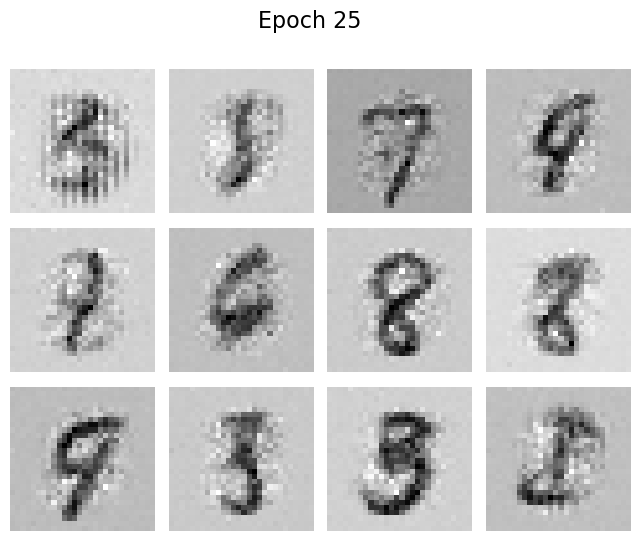

469it [00:14, 33.16it/s]


Epoch 26/30 |  Mean NLL (Loss): -1595.0336


469it [00:14, 33.24it/s]


Epoch 27/30 |  Mean NLL (Loss): -1599.9196


469it [00:13, 33.62it/s]


Epoch 28/30 |  Mean NLL (Loss): -1604.5231


469it [00:14, 32.66it/s]


Epoch 29/30 |  Mean NLL (Loss): -1608.8660


469it [00:14, 32.59it/s]


Epoch 30/30 |  Mean NLL (Loss): -1611.3864


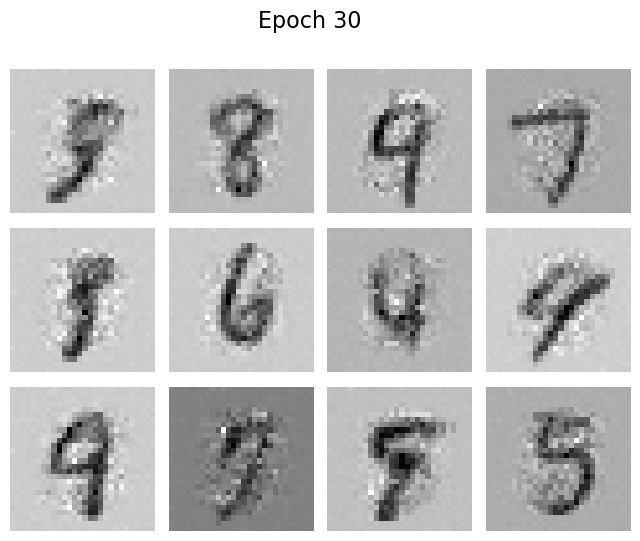

In [ ]:
def train_loop():

    print_every = 5
    optimizer = Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
    # Put model in training mode:
    model.train()
    # Main training loop:
    losses_ = np.zeros(epochs)

    for epoch in range(epochs):
        tot_mean_nll = 0.0

        for batch_id, (x, _) in tqdm(enumerate(train_loader)):
            # Zero gradients:
            model.zero_grad()
            # Move to device and flatten:
            x = x.to(device).view(-1, input_dim)
            # Call model:
            _, log_likelihood = model(x)
            # Compute mean NLL loss:
            loss = -tc.mean(log_likelihood)
            # Backpropagate:
            loss.backward()
            # Gradient clipping:
            tc.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            # Update weights:
            optimizer.step()
            # Add loss:
            tot_mean_nll += loss.item()

        # Take the mean over each epoch and print:
        mean_nll = tot_mean_nll / len(train_loader)
        losses_[epoch] = mean_nll
        print(f'Epoch {epoch+1}/{epochs} |  Mean NLL (Loss): {mean_nll:.4f}')
        if (epoch + 1) % print_every == 0:
            model.eval()
            sample_model(n_samples=12, title=f"Epoch {epoch + 1}")
            model.train()

    return losses_

losses = train_loop()

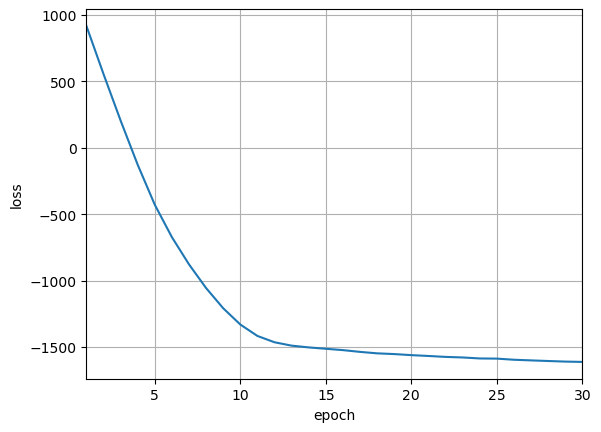

In [ ]:
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
plt.figure()
plt.plot(epoch_ax, losses)
plt.xlim([1, epochs])
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
plt.close()

### <u>Why Did the Logistic Work Better?</u>

We can only theorize and speculate, because the choice is ultimately empirical. Nonetheless, here are some potential reasons that might contribute:
+ **Tail Behavior**: The logistic has heavier tails than the Gaussian. This means that it can perhaps more effectively model the distribution of the data that has more extreme values or outliers. Since image data can have varied pixel distributions and MNIST digits might exhibit considerable variation in stroke, width, intensity, and other characteristic, the logistic's heavier tails could capture these aspects better.
+ **Quantization Effects**: MNIST grayscale images are quantized in [0,255]. When normalized and dequantized, these still reflect a discrete distribution rather than a truly continuous one. The S-shape of the logistic's cumulative distribution function might align more closely with slightly "stepped" nature of the quantized data than the Gaussian.